In [1]:
from bloqade import piecewise_linear, rydberg_h, var, load, save
from bloqade.atom_arrangement import ListOfLocations, Lieb, Square, Chain, Honeycomb, Kagome, Triangular, Rectangular
from bloqade.atom_arrangement import Square
from bloqade.emulate.ir.state_vector import StateVector, RydbergHamiltonian
from bloqade import get_capabilities
import numpy as np
import bloqade
import matplotlib.pyplot as plt

from bokeh.io import output_notebook 

output_notebook()

Loading BokehJS ...

Define a cost function based on the probability of obtaining a MIS. The MIS is calculated by the a separate Julia file using the bloqade subspace function and the tensor network method. 

In [2]:
sim_shots = 50

def mis_probability(output, bstrings):
    # bitstring results from simulator/Aquila
    output_bitstrings = list((output.report().counts()[0].keys()))
    # flip bits to align with classical solution representation
    for i, bitstring in enumerate(output_bitstrings):
        output_bitstrings[i] = ''.join('1' if x == '0' else '0' for x in bitstring)
    output_bitstrings = set(output_bitstrings)
    gt_bits = set(bstrings)
    # find the shared bitstrings
    sol = output_bitstrings.intersection(gt_bits)
    # sum the shots for the shared bitstrings (number of correctly found solutions)
    sum = 0
    sol = list(sol)
    # flip solution bits back for dictionary
    for i, bitstring in enumerate(sol):
        sol[i] = ''.join('1' if x == '0' else '0' for x in bitstring)
    counts_dict = output.report().counts()[0]
    for bitstring in list(sol):
        sum += counts_dict[bitstring]
    # calculate probability of the circuit finding an MIS
    return sum / sim_shots

def cost(params, bloqade_program):
    result = bloqade_program.run(sim_shots, args=(params[0], params[1]), **solver_options)
    # rydberg = result.report().rydberg_densities().to_numpy().sum()
    # P_mis = mis_probability(result)
    P_mis = mis_probability(result, bstrings)
    # P_is = mis_probability(result, isstate)
    print(f"Params: {params}, P_MIS: {P_mis}")
    return -P_mis

For local simulation, we sample a few 4x4 graphs with known exact solutions. Also, based on the degeneracy of the MIS states and the MIS state size, the hardness of the problem is computed. 

In [3]:
graphs4x4 = [ListOfLocations([(0.0, 0.0),(4.0, 0.0),(12.0, 0.0),(12.0, 4.0),(0.0, 8.0),(4.0, 8.0),(8.0, 8.0),(0.0, 12.0),(4.0, 12.0),(8.0, 12.0),(12.0, 12.0)]),
             ListOfLocations([(12.0, 0.0),(0.0, 4.0),(12.0, 4.0),(0.0, 8.0),(4.0, 8.0),(8.0, 8.0),(12.0, 8.0),(0.0, 12.0),(4.0, 12.0),(8.0, 12.0),(12.0, 12.0)]),
             ListOfLocations([(0.0, 0.0),(12.0, 0.0),(0.0, 4.0),(4.0, 4.0),(8.0, 4.0),(8.0, 8.0),(12.0, 8.0),(0.0, 12.0),(4.0, 12.0),(8.0, 12.0),(12.0, 12.0)]), 
             ListOfLocations([(0.0, 0.0),(4.0, 0.0),(8.0, 0.0),(12.0, 0.0),(12.0, 4.0),(4.0, 8.0),(8.0, 8.0),(12.0, 8.0),(0.0, 12.0),(4.0, 12.0),(12.0, 12.0)]),
             ]

mis_states = [["00100000100", "00000010100", "01000000010", "00000011000", "10000010000", "00010001000", "10000000010", 
               "00000001001", "00010000010", "01000000001", "01000000100", "10000000001", "00010000100", "00100000001"], 
              ["00000001100", "10000000010","00000001001","00000000011","01000000001","00001000010","10000001000","00010000001",
               "00010000100","00011000000", "00100000001"], 
              ["01000000010","00100000010","00000000110","10000000100","00001000100","00010000010","01000000001","10000000001",
               "00001000001","00011000000","00100000001"], 
              ["00100000100","00100000010","00000010001","00100001000","10000000100","10000000010","00100010000","01000001000",
               "01000000001","00110000000","01000000100","10000000001","00010000001"],]

hardness = [0.392, 0.5, 0.5, 0.4231]

We can begin with a naive solution, with the following waveforms. 

In [15]:
atom_pos = graphs4x4[0]
bstrings = mis_states[0]

peak = 0.3 # Rabi pulse comparable in size to detuning
d_max = 0.26 # computed by the equation for Rb

# durations and pulse piecewise function info for detuning and Rabi pulse
durations_delta = [0.15, 3.7, 0.15]
durations_omega = [0.15, 1.85, 1.85, 0.15]
delta_MHz=[-d_max,-d_max,d_max,d_max]
omega_MHz= [0,peak,peak,peak, 0]

# piecewise functions for detuning and Rabi pulse
Delta = piecewise_linear(durations_delta,[x*2*np.pi for x in delta_MHz])
Omega = piecewise_linear(durations_omega,[x*2*np.pi for x in omega_MHz])
# setting up the algorithm to run
program = rydberg_h(atom_pos, detuning= Delta, amplitude=Omega, phase=None)
bloqade_program = program.bloqade.python()
program.parse_sequence().show()

In [24]:
# show info about outputs
output = bloqade_program.run(shots=sim_shots, interaction_picture=True)
output.report().show()

In [17]:
# probability of measuring an MIS 
mis_probability(output, mis_states[0])

0.14

Not a bad starting point. Now we attempt to optimize the pulses. We first optimize the Rabi frequency...

In [4]:
atom_pos = graphs4x4[0]
bstrings = mis_states[0]

# variables
peak = var("Peak") 
time = var("Time") 

# starting points for piecewise delta values (detuning)
d_max = 0.2623
d_1 = -0.1007
d_2 = 0
d_3 = 0.1064

# implementing piecewise functions for pulses
durations_delta = [1, 1, 1, 1]
durations_omega = [0.15, 1.5, time, 2.35-time]
delta_MHz=[-d_max,d_1,d_2,d_3,d_max]
omega_MHz= [0,peak,peak,peak, 0]
Delta = piecewise_linear(durations_delta,[x*2*np.pi for x in delta_MHz])
Omega = piecewise_linear(durations_omega,[x*2*np.pi for x in omega_MHz])
# setting up algorithm to run 
program = rydberg_h(atom_pos, detuning= Delta, amplitude=Omega, phase=None, args=["Peak", "Time"])
bloqade_program = program.bloqade.python()

In [5]:
# Optimization algorithm (Nelder-Mead)
from scipy.optimize import minimize

solver_options = dict(
    atol=1e-4, rtol=1e-4, interaction_picture=True, solver_name="dop853")

peak_max = 5
time_max = 2
result = minimize(
    cost, (0.3, 0.9), args=(bloqade_program,), method="Nelder-Mead", 
    bounds=[(0, peak_max), (0, time_max)],
    options={'fatol':0.1}
)

Params: [0.3 0.9], P_MIS: 0.28
Params: [0.315 0.9  ], P_MIS: 0.36
Params: [0.3   0.945], P_MIS: 0.32
Params: [0.315 0.945], P_MIS: 0.24
Params: [0.30375 0.91125], P_MIS: 0.28
Params: [0.3075 0.9225], P_MIS: 0.26
Params: [0.3075 0.9   ], P_MIS: 0.2
Params: [0.315  0.9225], P_MIS: 0.22
Params: [0.313125 0.916875], P_MIS: 0.26
Params: [0.309375 0.905625], P_MIS: 0.22
Params: [0.3121875 0.9140625], P_MIS: 0.34
Params: [0.3196875 0.8915625], P_MIS: 0.26
Params: [0.31054688 0.91476563], P_MIS: 0.24
Params: [0.31359375 0.90703125], P_MIS: 0.28
Params: [0.31125 0.91125], P_MIS: 0.32
Params: [0.31265625 0.90421875], P_MIS: 0.28
Params: [0.31335937 0.90632813], P_MIS: 0.28
Params: [0.313125 0.905625], P_MIS: 0.28
Params: [0.31429688 0.90351563], P_MIS: 0.24
Params: [0.31382813 0.90210937], P_MIS: 0.28
Params: [0.31394531 0.90246094], P_MIS: 0.24
Params: [0.3140625 0.9028125], P_MIS: 0.34
Params: [0.31464844 0.90175781], P_MIS: 0.22
Params: [0.31441406 0.90105469], P_MIS: 0.3
Params: [0.31447266 

In [20]:
# running the algorithm on the simulator for different parameters (one of several)
peak = 0.3075 
time = 0.9

durations_omega = [0.15, 1.5, time, 2.35-time]
omega_MHz= [0,peak,peak,peak, 0]
Omega = piecewise_linear(durations_omega,[x*2*np.pi for x in omega_MHz])
program = rydberg_h(atom_pos, detuning= Delta, amplitude=Omega, phase=None)
bloqade_program = program.bloqade.python()

output = bloqade_program.run(shots=sim_shots, interaction_picture=True)
output.report().show()

In [26]:
# running the algorithm on the simulator for different parameters (one of several)
peak = 0.3149
time = 0.9001

durations_omega = [0.15, 1.5, time, 2.35-time]
omega_MHz= [0,peak,peak,peak, 0]
Omega = piecewise_linear(durations_omega,[x*2*np.pi for x in omega_MHz])
program = rydberg_h(atom_pos, detuning= Delta, amplitude=Omega, phase=None)
bloqade_program = program.bloqade.python()

output = bloqade_program.run(shots=sim_shots, interaction_picture=True)
output.report().show()

In [22]:
# running the algorithm on the simulator for different parameters (one of several)
peak = 0.30375
time = 0.91125

durations_omega = [0.15, 1.5, time, 2.35-time]
omega_MHz= [0,peak,peak,peak, 0]
Omega = piecewise_linear(durations_omega,[x*2*np.pi for x in omega_MHz])
program = rydberg_h(atom_pos, detuning= Delta, amplitude=Omega, phase=None)
bloqade_program = program.bloqade.python()

output = bloqade_program.run(shots=sim_shots, interaction_picture=True)
output.report().show()

Similarly, the detuning waveform is optimized as well in the same way, segmenting the waveform into multiple time components. The values are found to be: 
$d_\text{max} = 0.2623, 
d_1 = -0.1007, 
d_2 = 0, 
d_3 = 0.1064$. 

In [27]:
# optimized detuning algorithm
atom_pos = graphs4x4[0]
bstrings = mis_states[0]

peak = 0.289
time = 0.9703
d_max = 0.2623
d_1 = -0.1007
d_2 = 0
d_3 = 0.1064

durations_delta = [1.0, 1.0, 1.0, 1.0]
durations_omega = [0.15, 1.5, time, 2.35-time]
delta_MHz=[-d_max,d_1,d_2,d_3,d_max]
omega_MHz= [0,peak,peak, peak, 0]
Delta = piecewise_linear(durations_delta,[x*2*np.pi for x in delta_MHz])
Omega = piecewise_linear(durations_omega,[x*2*np.pi for x in omega_MHz])
program = rydberg_h(atom_pos, detuning= Delta, amplitude=Omega, phase=None)
bloqade_program = program.bloqade.python()
program.parse_register().show()
program.parse_sequence().show()

In [30]:
output = bloqade_program.run(shots=sim_shots, interaction_picture=True)
output.report().show()

In [32]:
# calculating probability of MIS on simulator
mis_probability(output, bstrings)

0.4

At the end, $R_b = \left(\frac{C_6}{\Delta}\right)^{1/6}$. Therefore, $R_b$ in units of the lattice constant $a$ is given by: 

In [16]:
# calculating Rb (Rydberg Blockade radius)
def rb(det): 
    return (862690/det)**(1/6)/4

rb(d_max)

3.048709805333831

We can sweep from a small ratio (King's ~ 1.4) to what we have to see how the performance scales. 

In [18]:
# performing sweep
max_det = [20, 10, 1, 0.2623]
for d in max_det:
    print("Rb = %.2f" % rb(d))

Rb = 1.48
Rb = 1.66
Rb = 2.44
Rb = 3.05


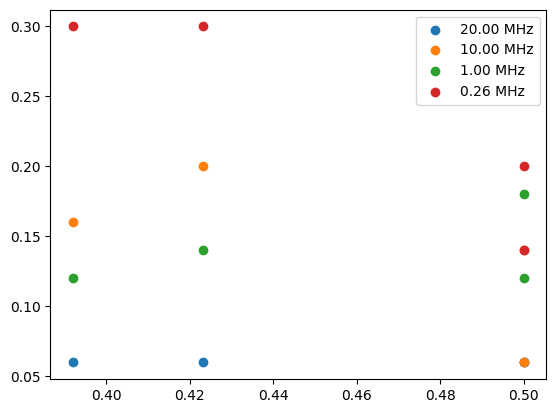

In [21]:
# graphing classical hardness (x axis) versus MIS probability (y axis)
# legend shows the detuning value 
p_mis = []

for md in max_det:
    f = md / d_max
    delta_MHz=[-md,d_1 * f,d_2 * f,d_3 * f,md]
    Delta = piecewise_linear(durations_delta,[x*2*np.pi for x in delta_MHz])
    p_mi = []
    for (i, graph) in enumerate(graphs4x4):
        atom_pos = graph
        program = rydberg_h(atom_pos, detuning= Delta, amplitude=Omega, phase=None)
        bloqade_program = program.bloqade.python()
        output = bloqade_program.run(shots=sim_shots, interaction_picture=True)
        p_mi.append(mis_probability(output, mis_states[i]))
    p_mis.append(p_mi)

for i, p_mi in enumerate(p_mis):
    plt.scatter(hardness, p_mi, label="%.2f MHz" % max_det[i])
plt.legend()

In [6]:
# 8x8 Aquila task with classically optimized parameters
atom_pos=ListOfLocations([(0.0, 0.0),(4.0, 0.0),(8.0, 0.0),(16.0, 0.0),(20.0, 0.0),(24.0, 0.0),(0.0, 4.0),(4.0, 4.0),(12.0, 4.0),(16.0, 4.0),(24.0, 4.0),(4.0, 8.0),(12.0, 8.0),(16.0, 8.0),
                          (20.0, 8.0),(24.0, 8.0),(28.0, 8.0),(0.0, 12.0),(4.0, 12.0),(8.0, 12.0),(12.0, 12.0),(16.0, 12.0),(20.0, 12.0),(24.0, 12.0),(0.0, 16.0),(4.0, 16.0),(16.0, 16.0),
                          (0.0, 20.0),(4.0, 20.0),(16.0, 20.0),(20.0, 20.0),(24.0, 20.0),(28.0, 20.0),(0.0, 24.0),(8.0, 24.0),(16.0, 24.0),(20.0, 24.0),(24.0, 24.0),(28.0, 24.0),
                          (0.0, 28.0),(4.0, 28.0),(12.0, 28.0),(16.0, 28.0),(20.0, 28.0),(28.0, 28.0)])
peak = 0.289
time = 0.89
d_max = 0.2623
d_1 = -0.1007
d_2 = 0
d_3 = 0.1064

durations_delta = [1.0, 1.0, 1.0, 1.0]
durations_omega = [0.15, 1.5, time, 2.35-time]
delta_MHz=[-d_max,d_1,d_2,d_3,d_max]
omega_MHz= [0,peak,peak, peak, 0]
Delta = piecewise_linear(durations_delta,[x*2*np.pi for x in delta_MHz])
Omega = piecewise_linear(durations_omega,[x*2*np.pi for x in omega_MHz])

program = rydberg_h(atom_pos, detuning= Delta, amplitude=Omega, phase=None)
# program.parse_register().show()
program.parse_sequence().show()

In [8]:
# the following code runs the task on Aquila
import os
from bloqade import load, save
if not os.path.isdir("data"):
    os.mkdir("data")
filename = os.path.join(os.path.abspath(""), "data", "testing.json")

In [9]:
# calls Aquila and saves to local file
if not os.path.isfile(filename):
    hw_batch = program.braket.aquila().run_async(shots=100)
    save(hw_batch, filename)

In [33]:
batch=load(filename)
batch.fetch()

                                             task ID     status  shots
0  arn:aws:braket:us-east-1:592242689881:quantum-...  Completed    100

In [34]:
batch.report().show()

In [ ]:
#determines the times to solution (TTS) for the optimized quantum solver process on simulation for lattices of size 3-7
from time import process_time
rng = np.random.default_rng(1234)
for md in max_det:
    f = md / d_max
    delta_MHz=[-md,d_1 * f,d_2 * f,d_3 * f,md]
    Delta = piecewise_linear(durations_delta,[x*2*np.pi for x in delta_MHz])
    p_mi = []
    for i in range(3, 8):
        atom_pos=Square(i, lattice_spacing=4).apply_defect_density(0.3, rng=rng).remove_vacant_sites()
        start = process_time()
        program = rydberg_h(atom_pos, detuning= Delta, amplitude=Omega, phase=None)
        bloqade_program = program.bloqade.python()
        output = bloqade_program.run(shots=sim_shots, interaction_picture=True)
        print(process_time() - start)